In [1]:
class Pars:
    pass

pars = Pars()
pars.cardTag = 'v16'
pars.category = '{c}'
pars.schemeFF = 'BLPR'
pars.useMVA = False
pars.dataType = 0
pars.unblinded = True
pars.noMCstats = False

scanTag = pars.cardTag+'Base'

plot_obs = True
plot_exp = True

# Import

In [2]:
import sys, os
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import commands
import numpy as np

import ROOT as rt
from combine_utilities import getUncertaintyFromLimitTree

Welcome to JupyROOT 6.12/07


In [3]:
def createCardName(a):
    c = a.cardTag + a.category + '_' + a.schemeFF
    if a.useMVA:
        c += '_MVA'+useMVA
    if a.asimov:
        c += '_Asimov'
    elif a.dataType:
        c += '_onlyB0'
        if a.dataType == 2:
            c += 'bar'
    if not a.unblinded:
        c += '_blinded'
    if a.noMCstats:
        c += '_NoMCstats'
    return c

In [4]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if plot_obs:
    CMS_lumi.extraText = "    Preliminary"
else:
    CMS_lumi.extraText = "    Simulation Preliminary"

expectedLumi = {'low':6.4, 'mid':20.7, 'high':26.4} #fb^-1
CMS_lumi.integrated_lumi = expectedLumi['high']

# Load results

In [5]:
resObs = {}
resExp = {}

for obs in [False, True]:
    d = resObs if obs else resExp

    pars.asimov = not obs
    card_name = createCardName(pars)
    print card_name

    for cat in ['low', 'mid', 'high', 'comb']:
        d[cat] = None
        
        if (not plot_obs and obs) or (not plot_exp and not obs):
            continue

        scanLoc = 'results/' + card_name.format(c=cat)
        scanLoc += '/higgsCombine'+scanTag+'.MultiDimFit.mH120.root'
        if not os.path.isfile(scanLoc):
            print scanLoc, 'not found'
            continue
        print cat
        try:
            d[cat] = getUncertaintyFromLimitTree(scanLoc)
        except:
            print 'ERROR in analysing results'
            print 'getUncertaintyFromLimitTree({})'.format(scanLoc)

v16{c}_BLPR_Asimov
results/v16low_BLPR_Asimov/higgsCombinev16Base.MultiDimFit.mH120.root not found
results/v16mid_BLPR_Asimov/higgsCombinev16Base.MultiDimFit.mH120.root not found
results/v16high_BLPR_Asimov/higgsCombinev16Base.MultiDimFit.mH120.root not found
results/v16comb_BLPR_Asimov/higgsCombinev16Base.MultiDimFit.mH120.root not found
v16{c}_BLPR
low
----------------------------------
R(D*) = 0.200 +0.020/-0.020 [9.8 %]
Sigma = 0.020
----------------------------------

mid
----------------------------------
R(D*) = 0.215 +0.018/-0.018 [8.3 %]
Sigma = 0.018
----------------------------------

high
----------------------------------
R(D*) = 0.276 +0.021/-0.021 [7.7 %]
Sigma = 0.021
----------------------------------

comb
----------------------------------
R(D*) = 0.243 +0.012/-0.012 [5.1 %]
Sigma = 0.012
----------------------------------



# Create plot

In [6]:
cOut = rt.TCanvas('cOut', 'cOut', 50, 50, 1200, 600)
grAux = rt.TGraph()
grAux.SetPoint(0, 0, 0)
grAux.SetPoint(1, 1, 1)
grAux.Draw('AP')

In [7]:
xMin = 0.2 if pars.unblinded else 0.15
xMax = 0.75 if pars.unblinded else 0.8

box = rt.TPave()
box.SetLineWidth(0)
box.SetFillStyle(1001)
box.SetBorderSize(0)
boxColors = [rt.kGreen+1, rt.kOrange]
boxHeight = 0.15

text = rt.TLatex()
text.SetTextAlign(12)
text.SetTextSize(0.04)
text.SetTextFont(42)
textColors = [1,rt.kRed-4]
textPosX = 0.42 if pars.unblinded else 0.5

legX1 = 0.7 if pars.unblinded else 0.75
leg = rt.TLegend(legX1, 0.3, 0.97, 0.8)
leg.SetBorderSize(0)

In [8]:
ypos = -1
ylabels = {}

pointObs = rt.TGraph()
pointExp = rt.TGraph()

lastDrawnIsComb = False

for cat in ['comb', 'low', 'mid', 'high']:
    aux = int(resExp[cat] is None) + int(resObs[cat] is None)
    displ = 0.07 + 0.5*boxHeight if aux == 0 else 0

    if aux < 2:
        ypos += 1
        if lastDrawnIsComb:
            ypos += 1
        if cat == 'comb': 
            ylabels[ypos] = 'Combined'
            lastDrawnIsComb = True
        else:
            ylabels[ypos] = cat.capitalize()
            lastDrawnIsComb = False
            
        for i, res in enumerate([resObs[cat], resExp[cat]]):
            if res is None:
                continue

            if i == 0:
                yAux = ypos + displ
                pointObs.SetPoint(pointObs.GetN(), res[0], yAux)
                box.SetFillStyle(1001)
            else:
                yAux = ypos - displ
                pointExp.SetPoint(pointExp.GetN(), res[0], yAux)
                box.SetFillStyle(3001)
            
            box.SetFillColor(boxColors[-1])
            b2 = box.DrawBox(float(res[-4]), yAux - 0.5*boxHeight, float(res[-1]), yAux + 0.5*boxHeight)
            box.SetFillColor(boxColors[-2])
            b1 = box.DrawBox(float(res[-3]), yAux - 0.5*boxHeight, float(res[-2]), yAux + 0.5*boxHeight)

            text.SetTextColor(textColors[i])
            l = text.DrawLatex(textPosX, yAux, '{:.3f} #pm {:.3f}'.format(res[0], res[3]))

In [9]:
l = rt.TLine()
l.SetLineStyle(9)
l.SetLineWidth(2)
box.SetFillStyle(1001)

RDst_Th = 0.258
uncRDst_Th = 0.005
box.SetFillColorAlpha(rt.kViolet-7, 0.5)
box.DrawBox(RDst_Th - uncRDst_Th, -1, RDst_Th + uncRDst_Th, ypos+1)
l.SetLineColor(rt.kViolet-7)
l.DrawLine(RDst_Th, -1, RDst_Th, ypos+1)
aux = '#splitline{SM prediction #pm 1#sigma}{'+'{:.3f} #pm {:.3f}'.format(RDst_Th,uncRDst_Th)+'}'
leg.AddEntry(l, aux, 'l')

RDst_avg = 0.295
uncRDst_avg = 0.014
box.SetFillColorAlpha(rt.kAzure+1, 0.5)
box.DrawBox(RDst_avg - uncRDst_avg, -1, RDst_avg + uncRDst_avg, ypos+1)
l2 = l.Clone('l2')
l2.SetLineColor(rt.kAzure+1)
l2.DrawLine(RDst_avg, -1, RDst_avg, ypos+1)
aux = '#splitline{Experimental Avg. #pm 1#sigma}{'+'{:.3f} #pm {:.3f}'.format(RDst_avg,uncRDst_avg)+'}'
leg.AddEntry(l2, aux, 'l');

In [10]:
pointObs.SetMarkerStyle(20)
pointObs.SetMarkerColor(textColors[0])
if pointObs.GetN(): 
    pointObs.Draw('P') 
    leg.AddEntry(pointObs, 'Observed', 'p')

pointExp.SetMarkerStyle(33)
pointExp.SetMarkerSize(1.5)
pointExp.SetMarkerColor(textColors[1])
if pointExp.GetN(): 
    pointExp.Draw('P') 
    leg.AddEntry(pointExp, 'Expected', 'p')

In [11]:
grAux.GetXaxis().SetLimits(xMin, xMax)
grAux.GetXaxis().SetTitle('R(D*)')
grAux.GetHistogram().SetMinimum(-1)
grAux.GetHistogram().SetMaximum(ypos+1)

ax = grAux.GetYaxis()
ax.SetNdivisions(-(ypos+2))
ax.ChangeLabel()
for i in range(1, ypos+4):
    if i-2 in ylabels.keys():
        ax.ChangeLabel(i, -1, -1, -1, -1, -1, ylabels[i-2])
    else:
        ax.ChangeLabel(i, -1, -1, -1, -1, -1, ' ')
ax.SetTickLength(0.0)

In [12]:
box.SetFillColor(boxColors[0])
leg.AddEntry(box, '#pm 1#sigma band', 'f')
box2 = box.Clone('box2')
box2.SetFillColor(boxColors[1])
leg.AddEntry(box2, '#pm 2#sigma band', 'f')

leg.Draw()

In [13]:
text.SetTextAlign(32)
text.SetTextColor(1)
text.SetTextSize(0.06)
if not pars.unblinded:
    text.DrawLatex(0.975*xMax, ypos+0.6, 'Blinded fit results')
else:
    text.DrawLatex(0.975*xMax, ypos+0.6, 'Fit results')

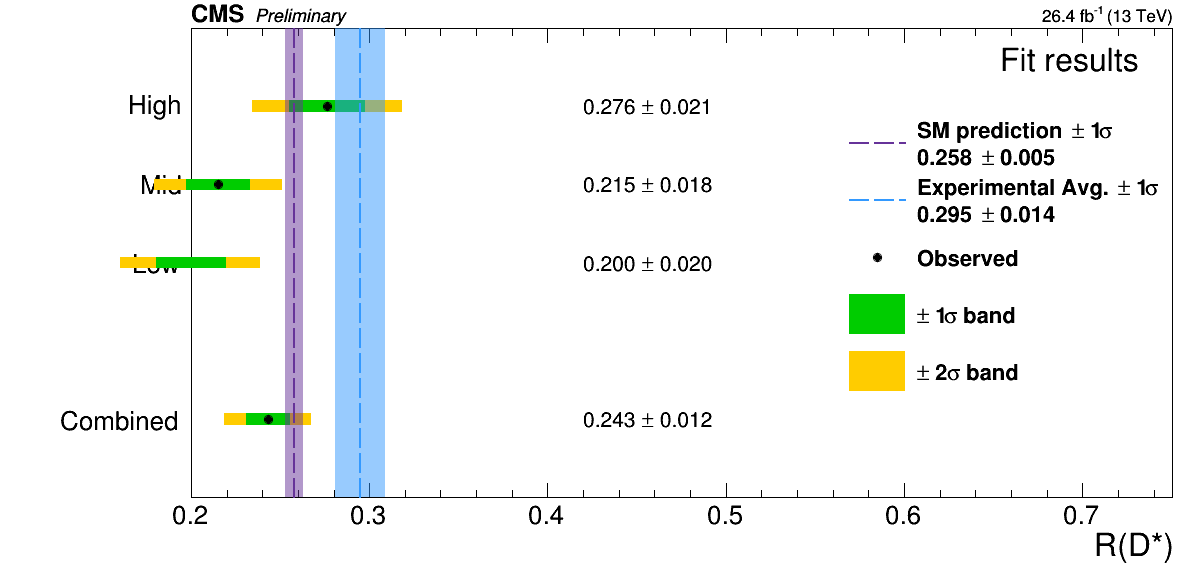

In [14]:
CMS_lumi.CMS_lumi(cOut, -1, 0, cmsTextSize=0.9, lumiTextSize=0.75)
cOut.Draw()
for v in [True, False]:
    pars.asimov = v
    cardName = createCardName(pars).format(c='comb')
    if os.path.isdir('results/'+cardName):
        name = '/fitResultsSummary_{}{}.png'.format(int(plot_obs), int(plot_exp))
        cOut.SaveAs('results/'+cardName+name)
        cOut.SaveAs('../../public_html/BPH_RDst/Combine/'+cardName+name)

In [15]:
print 'Current tension {:.1f} sigma'.format((RDst_Th - RDst_avg)/np.hypot(uncRDst_Th, uncRDst_avg))

r = RDst_avg
dr = uncRDst_avg/np.sqrt(2)
print 'Expected tension {:.1f} sigma'.format((RDst_Th - r)/np.hypot(uncRDst_Th, dr))

Current tension -2.5 sigma
Expected tension -3.3 sigma


In [16]:
np.sqrt((32**2 * 13**2) / (32**2 - 13**2))

14.212670403551895